# MIRRA: Maximum Income Ratio Redistribution Algorithm

In [463]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


In [464]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [465]:
"""
Redistribution based on targeted ratio of min to max incomes of a population.
Author: Michael Ellis
Copyright 2015 Ellis & Grant, Inc.
License: Gnu GPL
"""
from matplotlib import *
from copy import copy
import math
BEFORE = []  ## Array of incomes before redistribution
AFTER = []   ## Array of incomes after redistribution
LSPACE  = [] ## Used for horizontal axis in plots

def init_incomes():
    """
    Fill INCOMES array with 1000 incomes that simulate the 2012 distribution
    U.S. household incomes. 
    """
    import random
    global BEFORE, LSPACE
    BEFORE = []
    """
    Each entry in the list below is a 3-tuple describing and income bracket and the number
    of households per thousand in the bracket, e.g. (39, 5000, 9999) means that 39 per 1000 households
    have incomes between $5000 and $9999. See Table 1 in 
    https://fas.org/sgp/crs/misc/RS20811.pdf for DIST data.
    """
    DIST = [(34, 1, 5000), (39, 5000, 9999), (57, 10000, 14999),
            (58, 15000, 19999), (55, 20000, 24999), (54, 25000, 29999),
            (52, 30000, 34999), (48, 35000, 39999), (45, 40000, 44999),
            (45, 45000, 49999), (77, 50000, 59999), (69, 60000, 69999),
            (59, 70000, 79999), (49, 80000, 89999), (40, 90000, 99999), 
            (77, 100000, 124999), (47, 125000, 149999), (50, 150000, 199999),
            (21, 200000, 249999), (24, 250000, 499999),]

    ## Populate our pre-tax incomes array with 1000 simulated household incomes.
    ## For inital development, use a uniform distribution within each bracket.
    for bracket in DIST:
        n, imin, imax = bracket
        BEFORE.extend(random.sample(xrange(int(imin), int(imax)), n))
    
    assert len(BEFORE) == 1000
    
    ## Arrange incomes in ascending order and convert to float representation   
    BEFORE.sort()
    BEFORE = [float(i) for i in BEFORE]
    
    ## Fill the LSPACE array indices from 0 to 999
    LSPACE = range(len(BEFORE))
    
    return

def redistribute(ratio, show=False):
    """
    Apply the algorithm.
    
    Iteration:
        Compare ratio to highest/lowest
        Stop when ratio >= highest/lowest
        Find high incomes > ratio * lowest
        Subtract $1 from each
        Find low incomes < highest / ratio
        Distribute total subtracted from high incomes.
        Repeat (until stop condition)
    """
    
    global AFTER
    AFTER = copy(BEFORE)
    undistributed = 0 # accumulator for portion of pool not distributed after each pass

    while True:
        imax = AFTER[-1]  # highest adjusted income
        imin = AFTER[0]   # lowest adjusted income
        ## TEST FOR STOP CONDITION
        if ratio >= imax/imin:
            ## split the undistributed remainder among all
            # print undistributed
            npop = len(AFTER)
            share = undistributed/npop
            for i in xrange(npop):
                AFTER[i] += share
            # Make sure no money has disappeared or been created.    
            assert abs(sum(BEFORE) - sum(AFTER))/sum(BEFORE) < 1e6   
            break  # We're done
        else:
            index = -1  # end of list contains highest income
            pool = undistributed    # pool to be redistributed
            undistributed = 0
            ## Shave $1 from all high incomes relative to imin    
            while True:
                if AFTER[index]/imin > ratio:
                    AFTER[index] -= 1 # Subtract $1.00
                    pool += 1.0     # Add it to the pool
                    index -= 1        # index of next highest income
                else:
                    break # We've shaved all the high incomes
                    
            ## Count the low incomes (relative to imax)
            index = 0 # beginning of list has lowest income        
            count = 0
            while True:
                if imax / AFTER[index] > ratio:
                    count += 1
                else:
                    break
                index += 1
            ## Distribute shavings equally to low incomes.    
            incr = pool/count
            for i in xrange(count):
                if AFTER[i] + incr <= AFTER[i+1]: # protect monotonicity
                    AFTER[i] += incr
                else:
                    undistributed += incr
                    
    ## Plot the before and after incomes                
    plt.figure(1)            
    plt.plot(LSPACE, BEFORE, 'b', LSPACE, AFTER, 'g')
    plt.title("Ratio={}: Incomes before and after redistribution".format(ratio))                
    
    ## Show the effect on the 10 highest and lowest incomes
    showhilo(BEFORE, AFTER)
    
    ## Compute and plot the effective tax rates for each household
    efftax = effectivetax(BEFORE, AFTER)
    plt.figure(2)
    plt.plot(BEFORE, efftax)
    plt.title("Ratio={}: Effective tax rate vs household income.".format(ratio))
    

def showhilo(before, after):
    """
    Display function that shows 10 highest and lowest incomes.
    """
    def roundlist2int(lis):
        return [int(f) for f in np.rint(lis)]
    
    top10before = roundlist2int(before[-10:-1])
    top10after = [round(i) for i in after[-10:-1]]
    low10before = [round(i) for i in before[:10]]
    low10after = [round(i) for i in after[:10]]
    
    print "Lows Before: {}".format(low10before)
    print "Lows After: {}".format(low10after)
    print
    print "Highs Before: {}".format(top10before)
    print "Highs After: {}".format(top10after)
    
    
def effectivetax(before, after):
    """
    Compute effective tax rates (where positive)
    """
    efftax = []
    for b, a in zip(before, after):
        if b <= a:
            efftax.append(0.0)
        else:
            efftax.append((b - a)/float(b))
    return efftax


In [466]:
init_incomes()

Lows Before: [130.0, 138.0, 780.0, 924.0, 1154.0, 1234.0, 1253.0, 1678.0, 1712.0, 1911.0]
Lows After: [32072.0, 32073.0, 32180.0, 32213.0, 32279.0, 32305.0, 32312.0, 32479.0, 32493.0, 32583.0]

Highs Before: [387242, 395659, 409160, 410719, 423957, 444994, 450853, 466176, 479420]
Highs After: [260493.0, 264802.0, 271716.0, 272484.0, 278847.0, 289258.0, 292310.0, 299938.0, 307190.0]


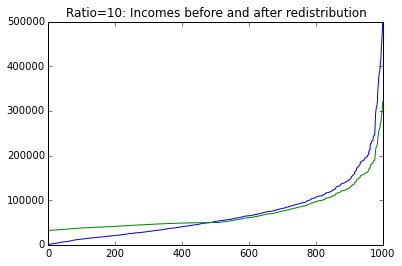

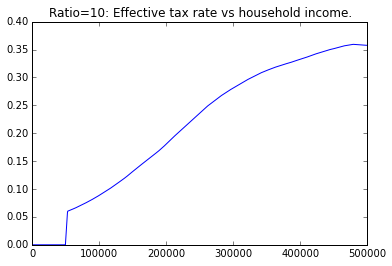

In [467]:
redistribute(10)


Lows Before: [130.0, 138.0, 780.0, 924.0, 1154.0, 1234.0, 1253.0, 1678.0, 1712.0, 1911.0]
Lows After: [22098.0, 22098.0, 22156.0, 22175.0, 22211.0, 22219.0, 22222.0, 22285.0, 22291.0, 22321.0]

Highs Before: [387242, 395659, 409160, 410719, 423957, 444994, 450853, 466176, 479420]
Highs After: [347982.0, 354942.0, 366107.0, 367377.0, 377925.0, 395197.0, 400077.0, 413039.0, 424357.0]


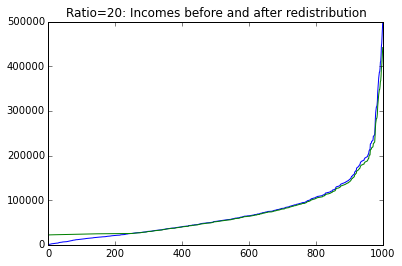

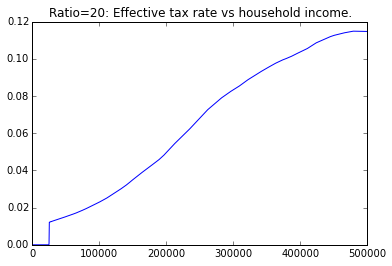

In [468]:
redistribute(20)


Lows Before: [130.0, 138.0, 780.0, 924.0, 1154.0, 1234.0, 1253.0, 1678.0, 1712.0, 1911.0]
Lows After: [9803.0, 9803.0, 9823.0, 9826.0, 9831.0, 9832.0, 9833.0, 9845.0, 9846.0, 9851.0]

Highs Before: [387242, 395659, 409160, 410719, 423957, 444994, 450853, 466176, 479420]
Highs After: [381117.0, 389341.0, 402513.0, 404032.0, 416907.0, 437387.0, 443120.0, 458092.0, 471077.0]


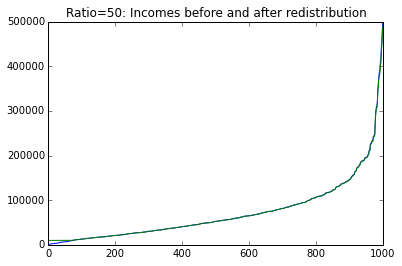

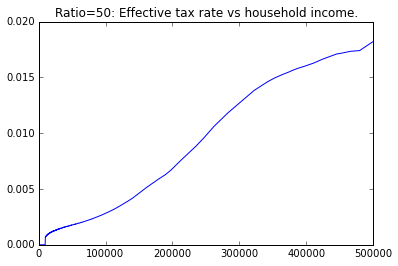

In [469]:
redistribute(50)